In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import torch
import torchvision

First importing the images data from the csv file and then splitting the labeelled data into training and test dataset. 

In [2]:
data = pd.read_csv('digit-recognizer/train.csv')
data = data.dropna()
rows, cols = data.shape

np.random.shuffle(np.arange(rows))
test_rows = np.floor(rows * 0.15)
test = data.loc[:test_rows, :]
train = data.loc[test_rows:, :]
print('Shape of training dataset: ', train.shape)
print('Shape of test dataset: ', test.shape)

Shape of training dataset:  (35700, 785)
Shape of test dataset:  (6301, 785)


Before modeling, it is recommended to understand the data. For that, select 8 images from the training dataset. After selection, drop the label of the data. 

In [3]:
random_sel = train.sample(8)
print(random_sel.shape)
image_features = random_sel.drop('label', axis=1)
print(image_features.shape)

(8, 785)
(8, 784)


Next, the image vectors are converted into 2D image (height and weight) while retaining the number of images as the first dimension of the reshaped array. 

In [4]:
image_batch = (torch.Tensor(image_features.values/255.)).reshape((-1, 28, 28))
print(image_batch.shape)

torch.Size([8, 28, 28])


The images tensor is now converted into a grid. 

In [5]:
image_batch2 = image_batch.unsqueeze(1)
image_batch2.shape

torch.Size([8, 1, 28, 28])

`torch.unsqueeze()` returns a new tensor with a dimension of size one inserted at the specified position. Here, the `image_batch` is changed into tensor of 4 dimensions with a new dimension of size $1$ added as the second dimension. This tensor is of the shape format (B x C x H x W) where B is the Batch size and C is the Channel size. For a single channel image, the size of the dimension is $1$.  

The next function `torchvision.utils.make_grid()` takes the input tensor in the format (B x C x H x W).     
2nd dimension of grid will be: H + padding * 2  
3rd dimension of grid will be: B * H + padding * (B + 1)   


In [20]:
grid = torchvision.utils.make_grid(image_batch.unsqueeze(1), nrow=8, padding=4)
print(grid.shape)

torch.Size([3, 36, 260])


(-0.5, 259.5, 35.5, -0.5)

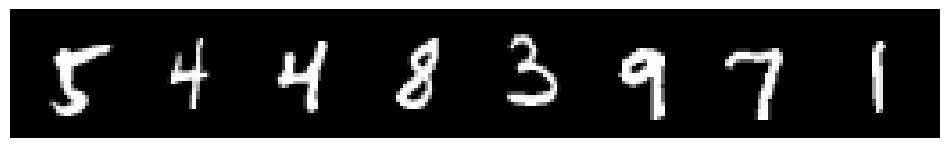

In [21]:
plt.figure(figsize = (12, 12))
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')

In [34]:
train_features = train.drop('label', axis=1)
train_target = train['label']

test_features = test.drop('label', axis=1)
test_target = test['label']

In [35]:
X_train_tensor = torch.tensor(train_features.values, dtype=torch.float)
X_test_tensor = torch.tensor(test_features.values, dtype=torch.float)

Y_train_tensor = torch.tensor(train_target.values, dtype=torch.long)
Y_test_tensor = torch.tensor(test_target.values, dtype=torch.long)

In [36]:
print(X_train_tensor.shape)
print(Y_train_tensor.shape)
print(X_test_tensor.shape)
print(Y_test_tensor.shape)

torch.Size([35700, 784])
torch.Size([35700])
torch.Size([6301, 784])
torch.Size([6301])


In [37]:
X_train_tensor = X_train_tensor.reshape(-1, 1, 28, 28)
X_test_tensor = X_test_tensor.reshape(-1, 1, 28, 28)

In [38]:
print(X_train_tensor.shape)
print(Y_train_tensor.shape)
print(X_test_tensor.shape)
print(Y_test_tensor.shape)

torch.Size([35700, 1, 28, 28])
torch.Size([35700])
torch.Size([6301, 1, 28, 28])
torch.Size([6301])


In [39]:
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score, precision_score, recall_score

In [129]:
# Number of channels in the input image
in_size = 1 # Since grayscale image

# Two hidden layers in the neural network
# First has depth of 16 features/nodes
# Second has depth of 32 features/nodes
hid1_size = 16
hid2_size = 32

# Output from the final linear layer
out_size = 10

# Convolution kernel size of 5 x 5
k_conv_size = 5


class ConvNet(nn.Module):
    
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_size, hid1_size, k_conv_size),
            nn.BatchNorm2d(hid1_size), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(hid1_size, hid2_size, k_conv_size), 
            nn.BatchNorm2d(hid2_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        
        self.fc = nn.Linear(512, out_size)
        
    def forward(self, x):
        out = self.layer1(x)
        # print(out.shape)

        out = self.layer2(out)
        # print(out.shape)

        out = out.reshape(out.size(0), -1)
        # print(out.shape)

        out = self.fc(out)
        # print(out.shape)

        # return out (Without softmax function)
        return F.log_softmax(out, dim=-1)
    

model = ConvNet()
model

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

In [130]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


Two major loss functions are used for multi-class classification: 

    1. Cross Entropy Function
    2. Negative Log-Likelihood Function
    
The difference between the two is that in Pytorch, Cross Entropy Loss Function first applies the log softmax activation function before calculating the negative log likelihood loss. 
Whereas the Negative log-likelihood 

In [131]:
learning_rate = 0.01

# loss_criterion = nn.CrossEntropyLoss()
loss_criterion = nn.NLLLoss() # Negative Loss Likelihood, used with softmax function

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learlearning_rate, momentum=0.9)

In [132]:
epochs = 20
loss_values = list()

In [133]:
for epoch in range(epochs):
    outputs = model(X_train_tensor)
    loss = loss_criterion(outputs, Y_train_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print(f'Epoch - {epoch+1}, loss - {loss.item()}')
    loss_values.append(loss.item())

Epoch - 1, loss - 2.397914409637451
Epoch - 2, loss - 3.2870352268218994
Epoch - 3, loss - 1.9077205657958984
Epoch - 4, loss - 1.2468693256378174
Epoch - 5, loss - 1.4038819074630737
Epoch - 6, loss - 1.1547801494598389
Epoch - 7, loss - 0.944354772567749
Epoch - 8, loss - 0.7047223448753357
Epoch - 9, loss - 0.5261828899383545
Epoch - 10, loss - 0.4621257781982422
Epoch - 11, loss - 0.4682979881763458
Epoch - 12, loss - 0.47883716225624084
Epoch - 13, loss - 0.43240538239479065
Epoch - 14, loss - 0.35938113927841187
Epoch - 15, loss - 0.31189998984336853
Epoch - 16, loss - 0.2931482493877411
Epoch - 17, loss - 0.2860753536224365
Epoch - 18, loss - 0.28045710921287537
Epoch - 19, loss - 0.2738623321056366
Epoch - 20, loss - 0.26434850692749023


Text(0, 0.5, 'Loss')

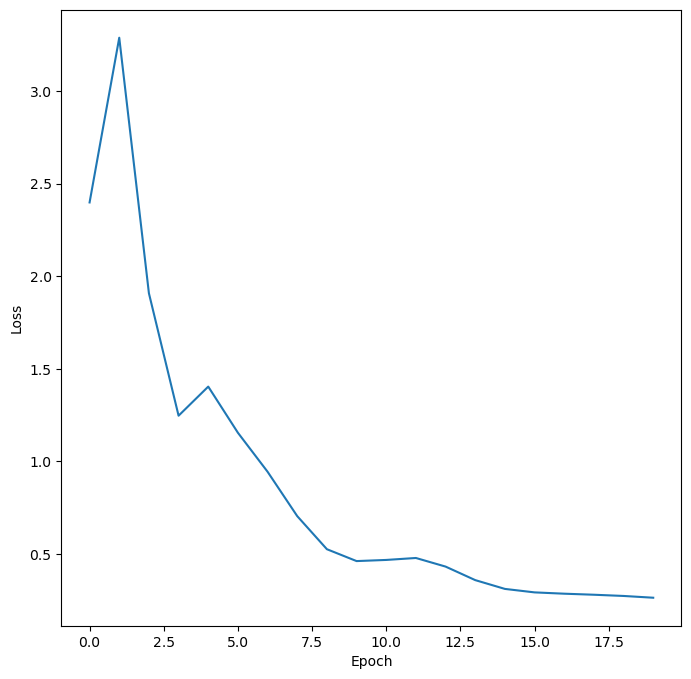

In [134]:
x = (range(0, 20))

plt.figure(figsize = (8, 8))
plt.plot(x, loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [135]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    
    y_test = Y_test_tensor.cpu().numpy()
    predicted = predicted.cpu()
    
    print('Accuracy: ', accuracy_score(predicted, y_test))
    print('Precision: ', precision_score(predicted, y_test, average='weighted'))
    print('Recall: ', recall_score(predicted, y_test, average='weighted'))

Accuracy:  0.9257260752261546
Precision:  0.9276940945975569
Recall:  0.9257260752261546
